In [5]:
import sys
sys.path.append('../')

from models.baseline import LyftModel
from configs.baseline import *
from utils import save_configs
from copy import deepcopy

import os
from tempfile import gettempdir
from IPython.display import display, clear_output
import PIL
from pathlib import Path

from tqdm import tqdm
import numpy as np
from l5kit.configs import load_config_data
import l5kit
from l5kit.evaluation.csv_utils import write_pred_csv
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateLogger
import matplotlib.pyplot as plt

pl.seed_everything(42)
os.environ["L5KIT_DATA_FOLDER"] = PATH_TO_DATA

ModuleNotFoundError: No module named 'models'

In [3]:
def visualize_trajectory(dataset, index, title="target_positions movement with draw_trajectory"):
    plt.figure(figsize = (8,6))
    data = dataset[index]
    im = data["image"].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)
    target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
    draw_trajectory(im, target_positions_pixels, rgb_color=TARGET_POINTS_COLOR)#, yaws=data["target_yaws"], rgb_color=TARGET_POINTS_COLOR)

    plt.title(title)
    plt.imshow(im[::-1])
    plt.show()

def visualize_gif(dataset, scene_idx, cfg):
    scene_idx = 1
    indexes = dataset.get_scene_indices(scene_idx)
    images = []

    for idx in indexes:

        data = dataset[idx]
        im = data["image"].transpose(1, 2, 0)
        im = dataset.rasterizer.to_rgb(im)

        target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
        center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
        draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])
        clear_output(wait=True)
        display(PIL.Image.fromarray(im[::-1]))

In [4]:
# get config
agent_cfg = load_config_data('../configs/agent_motion_config.yaml')

# agent_cfg['train_data_loader']['key'] = os.path.join(os.getcwd(), agent_cfg['train_data_loader']['key'])
agent_cfg['val_data_loader']['key'] = os.path.join(os.getcwd(), '../', agent_cfg['val_data_loader']['key'])
# agent_cfg['test_data_loader']['key'] = os.path.join(PATH_TO_DATA, agent_cfg['test_data_loader']['key'])

# train_cfg = agent_cfg["train_data_loader"]
validation_cfg = agent_cfg["val_data_loader"]
agent_cfg["raster_params"]["map_type"] = "py_semantic"
# test_cfg = agent_cfg["test_data_loader"]

dm = LocalDataManager()
val_rasterizer = l5kit.rasterization.build_rasterizer(agent_cfg, dm)


val_zarr = ChunkedDataset(dm.require(validation_cfg["key"])).open()
val_dataset = EgoDataset(agent_cfg, val_zarr, val_rasterizer)
# val_dataset = torch.utils.data.Subset(val_dataset,
#                                       range(0, int(len(val_dataset) * hyperparams['val_fraction'])))

# val_dataloader = DataLoader(val_dataset,
#                             shuffle=hyperparams["shuffle_val"],
#                             batch_size=hyperparams["val_batch_size"],
#                             num_workers=hyperparams["num_workers"])
# print(f'Validation dataloader: {len(val_dataloader)}')

NameError: name 'load_config_data' is not defined

In [4]:
# visualize_gif(val_dataset, 1, agent_cfg)

In [5]:
# visualize_trajectory(val_dataset, 10)

In [6]:
# # ===== GENERATE AND LOAD CHOPPED DATASET
# num_frames_to_chop = 100

# eval_base_path = create_chopped_dataset(dm.require(validation_cfg["key"]),
#                                         agent_cfg["raster_params"]["filter_agents_threshold"], 
#                                         num_frames_to_chop,
#                                         agent_cfg["model_params"]["future_num_frames"],
#                                         MIN_FUTURE_STEPS)

In [7]:
eval_base_path = os.path.join(f'{os.getcwd()}', '../', 'validate_chopped_100')

In [8]:
eval_zarr_path = str(Path(eval_base_path) / Path(dm.require(validation_cfg["key"])).name)
eval_mask_path = str(Path(eval_base_path) / "mask.npz")
eval_gt_path = str(Path(eval_base_path) / "gt.csv")

eval_zarr = ChunkedDataset(eval_zarr_path).open()
eval_mask = np.load(eval_mask_path)["arr_0"]
# ===== INIT DATASET AND LOAD MASK
eval_dataset = AgentDataset(agent_cfg, eval_zarr, val_rasterizer, agents_mask=eval_mask)
eval_dataloader = DataLoader(eval_dataset, shuffle=hyperparams['shuffle_val'], batch_size=hyperparams['val_batch_size'], 
                             num_workers=hyperparams["num_workers"])
print(eval_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16220    |  1622000   | 125423254  |    11733321   |      45.06      |        100.00        |        77.33         |        10.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


/home/vlad/Documents/envs/lyft/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: you're running with a custom agents_mask
  


### Prediction

In [9]:
checkpoint_path = '../results/resnet50_resume_80it_exp_lr_decay_2020-10-04_13:47/checkpoints/epoch=2-val_loss=0.75.ckpt'
criterion = torch.nn.MSELoss(reduction="none")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = LyftModel.load_from_checkpoint(checkpoint_path, criterion=criterion).to(device).eval()

model_untrained = LyftModel(agent_cfg, criterion, 1e-3).to(device).eval()

In [10]:
# # ==== EVAL LOOP
# model.eval()
# torch.set_grad_enabled(False)

# # store information for evaluation
# future_coords_offsets_pd = []
# timestamps = []
# agent_ids = []

# for idx, data in enumerate(tqdm(eval_dataloader)):
#     inputs = torch.tensor(data["image"], device=device)

#     # convert agent coordinates into world offsets
#     targets = torch.tensor(data["target_positions"], device=device)
#     agents_coords = model(inputs).reshape(targets.shape).cpu().numpy().copy()
#     world_from_agents = data["world_from_agent"].numpy()
#     centroids = data["centroid"].numpy()
#     coords_offset = []

#     for agent_coords, world_from_agent, centroid in zip(agents_coords, world_from_agents, centroids):
#         coords_offset.append(transform_points(agent_coords, world_from_agent) - centroid[:2])

#     future_coords_offsets_pd.append(np.stack(coords_offset))
#     timestamps.append(data["timestamp"].numpy().copy())
#     agent_ids.append(data["track_id"].numpy().copy())
    
#     if idx == 10:
#         break

### Storing predictions

In [11]:
# pred_path = f"{gettempdir()}/pred.csv"

# write_pred_csv(pred_path,
#                timestamps=np.concatenate(timestamps),
#                track_ids=np.concatenate(agent_ids),
#                coords=np.concatenate(future_coords_offsets_pd),
#               )

### Computing metrics

In [12]:
# metrics = compute_metrics_csv(eval_gt_path, pred_path, [neg_multi_log_likelihood, time_displace])
# for metric_name, metric_mean in metrics.items():
#     print(metric_name, metric_mean)

### Visualization

In [15]:
torch.set_grad_enabled(False)

# build a dict to retrieve future trajectories from GT
# gt_rows = {}
# for row in read_gt_csv(eval_gt_path):
#     gt_rows[row["track_id"] + row["timestamp"]] = row["coord"]
    

eval_ego_dataset = EgoDataset(agent_cfg, eval_dataset.dataset, val_rasterizer)

def visualize_pred(model, eval_zarr, eval_ego_dataset, eval_dataset, agent_cfg, eval_gt_path, limit=1):
    gt_rows = {}
    # build a dict to retrieve future trajectories from GT
    for row in read_gt_csv(eval_gt_path):
        gt_rows[row["track_id"] + row["timestamp"]] = row["coord"]
        gt_rows[row["track_id"] + row["timestamp"] + '_avail'] = row['avail']
        
    i = 0
    for frame_number in range(99, len(eval_zarr.frames), 100):  # start from last frame of scene_0 and increase by 100
        agent_indices = eval_dataset.get_frame_indices(frame_number) 
        if not len(agent_indices):
            continue

        # get AV point-of-view frame
        data_ego = eval_ego_dataset[frame_number]
        im_ego = val_rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
        center = np.asarray(agent_cfg["raster_params"]["ego_center"]) * agent_cfg["raster_params"]["raster_size"]

        predicted_positions = []
        target_positions = []
        target_availabilities = []

        for v_index in agent_indices:
            data_agent = eval_dataset[v_index]

            out_net = model(torch.from_numpy(data_agent["image"]).unsqueeze(0).to(device))
            out_pos = out_net[0].reshape(-1, 2).detach().cpu().numpy()
            # store absolute world coordinates
            predicted_positions.append(transform_points(out_pos, data_agent["world_from_agent"]))
            # retrieve target positions from the GT and store as absolute coordinates
            track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
            target_positions.append(gt_rows[str(track_id) + str(timestamp)] + data_agent["centroid"][:2])
            
            


        # convert coordinates to AV point-of-view so we can draw them
        predicted_positions = transform_points(np.concatenate(predicted_positions), data_ego["raster_from_world"])
        target_positions = transform_points(np.concatenate(target_positions), data_ego["raster_from_world"])
        
#         score = neg_multi_log_likelihood(target_positions,
#                                          predicted_positions, 
#                                          np.ones_like(predicted_positions.shape[0]),
#                                          gt_rows[str(track_id) + str(timestamp) + '_avail'])
        
        im_ego_copy = deepcopy(im_ego)
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
        
        draw_trajectory(im_ego_copy, target_positions, TARGET_POINTS_COLOR)
        ax1.set_title('Prediction')
        
        draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
        ax2.set_title('Ground Truth')
        
        ax1.imshow(im_ego[::-1])
        ax2.imshow(im_ego_copy[::-1])
        plt.show()
        

        i += 1
        
        if i == limit:
            break

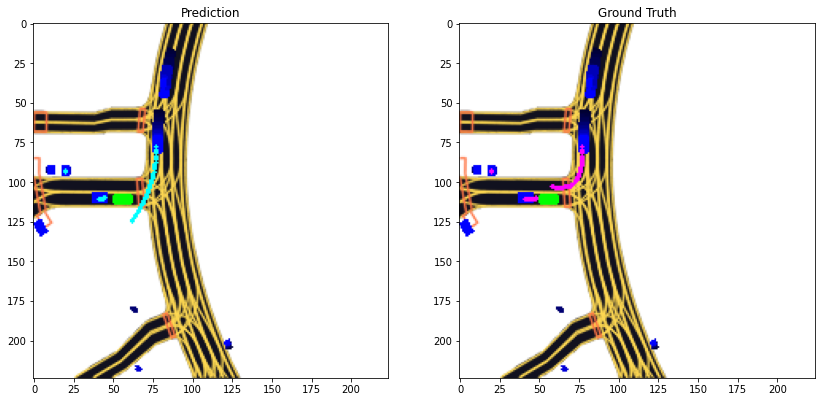

In [16]:
visualize_pred(model, eval_zarr, eval_ego_dataset, eval_dataset, agent_cfg, eval_gt_path, limit=1)